In [0]:
%pip install prophet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/14.4 MB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 74.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/954.8 kB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 10.2 MB/s eta 0:00:00
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
import cmdstanpy


14:58:26 - cmdstanpy - INFO - Chain [1] start processing
14:58:26 - cmdstanpy - INFO - Chain [1] done processing
14:58:26 - cmdstanpy - INFO - Chain [1] start processing
14:58:26 - cmdstanpy - INFO - Chain [1] done processing
14:58:26 - cmdstanpy - INFO - Chain [1] start processing
14:58:26 - cmdstanpy - INFO - Chain [1] done processing
14:58:26 - cmdstanpy - INFO - Chain [1] start processing
14:58:26 - cmdstanpy - INFO - Chain [1] done processing


❌ помилка в gold шару: [Errno 5] Input/output error: '/dbfs/tmp/gold_forecast_prophet_plot.png'

📄 Лог моделі та графика оновлен


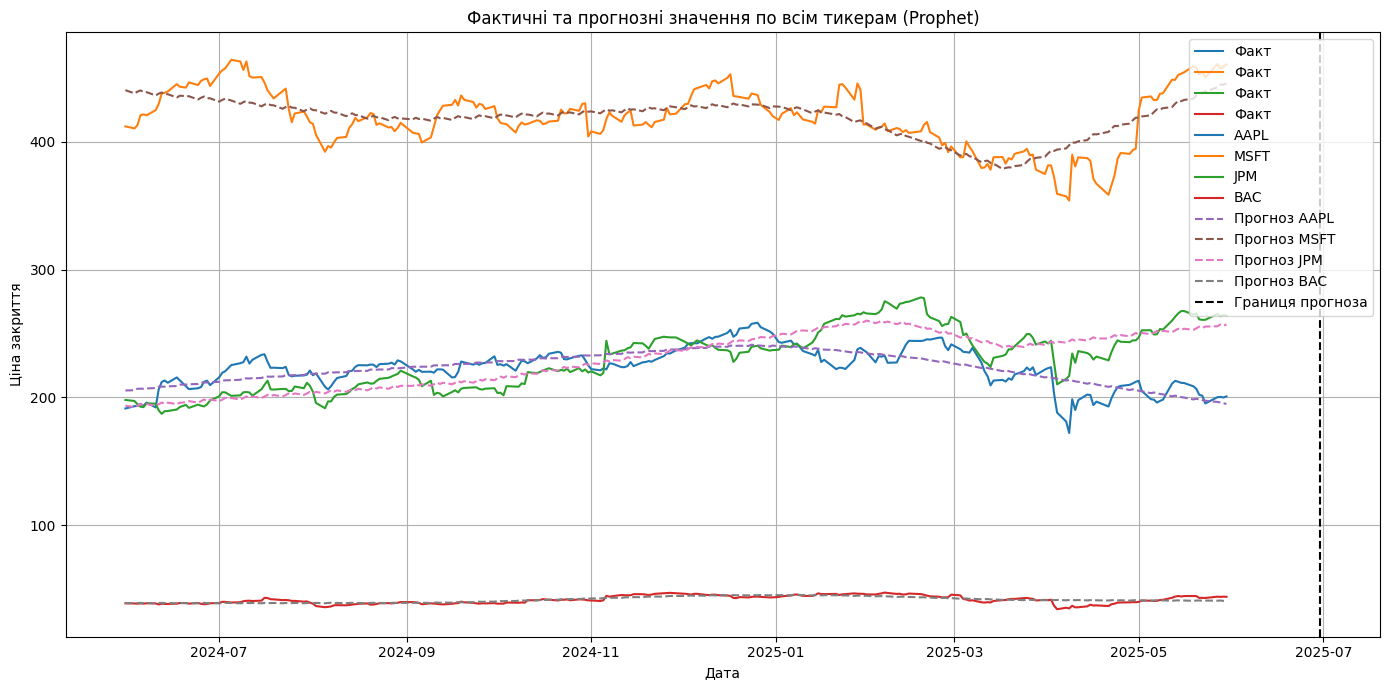

In [0]:
# 03_gold_sector_aggregation_with_prophet.py

from pyspark.sql.functions import col, avg, sum as _sum
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
import os

log_entry = []

try:
    silver_df = spark.table("silver_sector_data")

    # Фильтрація на Q1+Q2
    silver_df_filtered = silver_df.filter((col("date") >= "2025-01-01") & (col("date") <= "2025-06-30"))

    gold_df = silver_df_filtered.groupBy("Ticker", "Sector") \
        .agg(
            avg("Close").alias("average_close"),
            _sum("Volume").alias("total_volume")
        )

    gold_df.write.format("delta").mode("overwrite").saveAsTable("gold_sector_summary")

    pdf = silver_df.select("date", "Ticker", "Close").toPandas()
    pdf["date"] = pd.to_datetime(pdf["date"])

    forecast_results = []

    for ticker in pdf["Ticker"].unique():
        df_ticker = pdf[pdf["Ticker"] == ticker].sort_values("date")

        df_train = df_ticker[df_ticker["date"] <= "2025-06-30"]
        df_future = df_ticker[df_ticker["date"] > "2025-06-30"]

        # підготовка даних для Prophet
        prophet_df = df_train.rename(columns={"date": "ds", "Close": "y"})[["ds", "y"]]

        model = Prophet(daily_seasonality=True)
        model.fit(prophet_df)

        # створення DataFrame для прогноза на період (факт + майбутне)
        future = model.make_future_dataframe(periods=len(df_future), freq='D')
        forecast = model.predict(future)

        # об'єдання фвктичних та прогнозних даних
        forecast_subset = forecast[["ds", "yhat"]].rename(columns={"ds": "date", "yhat": "forecast"})
        actual = df_ticker[["date", "Close"]].rename(columns={"Close": "actual"})

        merged = pd.merge(forecast_subset, actual, on="date", how="left")
        merged["Ticker"] = ticker
        forecast_results.append(merged)

    final_df = pd.concat(forecast_results)
    final_df["date"] = pd.to_datetime(final_df["date"])

    plt.figure(figsize=(14, 7))

    # лінії факту
    sns.lineplot(data=final_df, x="date", y="actual", hue="Ticker", style=None, markers=False, legend="brief", label="Факт")

    # лінії прогноза використання пунктир
    for ticker in final_df["Ticker"].unique():
        subset = final_df[final_df["Ticker"] == ticker]
        plt.plot(subset["date"], subset["forecast"], linestyle='--', label=f"Прогноз {ticker}")

    # Вертикальна лінія розділу прогноза 
    plt.axvline(pd.to_datetime("2025-06-30"), color="black", linestyle="--", label="Границя прогноза")

    plt.title("Фактичні та прогнозні значення по всім тикерам (Prophet)")
    plt.xlabel("Дата")
    plt.ylabel("Ціна закриття")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # збереження графика в dbfs/tmp/
    plot_path = "/dbfs/tmp/gold_forecast_prophet_plot.png"
    plt.savefig(plot_path)
    plt.close()

    # Лог успеху
    log_entry.append({
        "step": "gold_model",
        "layer": "gold",
        "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "status": "success",
        "rows_processed": len(final_df),
        "comment": "Успішний прогноз по всім тикерам с Prophet"
    })

except Exception as e:
    log_entry.append({
        "step": "gold_model",
        "layer": "gold",
        "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "status": f"error: {str(e)}",
        "rows_processed": 0,
        "comment": "помилка в gold слое"
    })
    print(f"❌ помилка в gold шару: {e}")

finally:
    spark.createDataFrame(log_entry).write.format("delta").mode("append").saveAsTable("pipeline_logs")
    print("\n📄 Лог моделі та графика оновлен")

if log_entry[0]["status"] == "success":
    display(spark.table("gold_sector_summary").limit(10))

    # Зображення збереженого графика в Databricks HTML
    displayHTML(f'<img src="/files/tmp/gold_forecast_prophet_plot.png" style="max-width:100%; height:auto;">')
